## Create a new model

In [4]:
"""
.. module:: 
    :synopsis: Module doing stuff...

.. moduleauthor:: Marc Javin
"""

from odynn.models.model import BioNeuron
from odynn import utils
from pylab import plt
import random
import numpy as np
import tensorflow as tf


# Class for our new model
class LeakyIntegrate(BioNeuron):
    # Membrane capacitance, leakage conductance and reversal potential
    default_params = {'C_m': 1., 'g_L': 0.1, 'E_L': -60.}
    # Initial value for the voltage
    default_init_state = np.array([-60.])
    # Constraints for optimization
    _constraints_dic = {'C_m': [0.5, 40.],
                        'g_L': [1e-9, 10.]}

    def __init__(self, init_p, tensors=False, dt=0.1):
        BioNeuron.__init__(self, init_p=init_p, tensors=tensors, dt=dt)

    def _i_L(self, V):
        return self._param['g_L'] * (self._param['E_L'] - V)

    def step(self, X, i_inj):
        # Update the voltage
        V = X[0]
        V = (V * (self._param['C_m'] / self.dt) + (i_inj + self._param['g_L'] * self._param['E_L'])) /\
            ((self._param['C_m'] / self.dt) + self._param['g_L'])
        # For use of both Python and Tensorflow
        if self._tensors:
            return tf.stack([V])
        else:
            return np.array([V])

    @staticmethod
    def get_random():
        # Useful later
        return {'C_m': random.uniform(0.5, 40.),
                'g_L': random.uniform(1e-5, 10.),
                'E_L': random.uniform(-70., -45.)}

    def plot_results(self, ts, i_inj_values, X, ca_true=None, suffix="", show=True, save=False):

        V = X[:,0]
        il = self._i_L(V)

        plt.figure()

        plt.subplot(3, 1, 1)
        plt.plot(ts, V, 'k')
        plt.title('Leaky Integrator Neuron')
        plt.ylabel('V (mV)')

        plt.subplot(3, 1, 2)
        plt.plot(ts, il, 'g', label='$I_{L}$')
        plt.ylabel('Current')
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(ts, i_inj_values, 'b')
        plt.xlabel('t (ms)')
        plt.ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')
        # plt.ylim(-1, 40)

        utils.save_show(show, save, name='Results_{}'.format(suffix), dpi=300)

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [6]:
from odynn.models import cfg_model
cfg_model.NEURON_MODEL = LeakyIntegrate

from odynn import nsimul as ns
import scipy as sp

___________Neuron Simulation____________
Simulation time : 0.046761274337768555


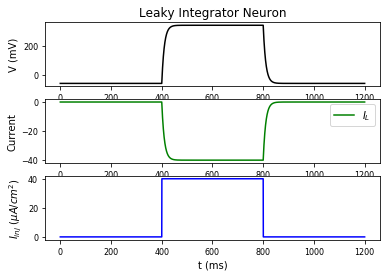

[array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 1.1997e+03, 1.1998e+03,
        1.1999e+03]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 [array([-60., -60., -60., ..., -60., -60., -60.])]]

In [7]:
t = sp.arange(0., 1200., 0.1)
i = 40. * ((t > 400) & (t < 800))
ns.simul(t=t, i_inj=i, show=True, save=False)